A pipeline to aggregate census-tract level data of social vulnerability information to the county level and re-evaluating thresholds for disadvantaged counties.

Dataset: https://screeningtool.geoplatform.gov/en/methodology#3/33.47/-97.5

In [6]:
import math
from pathlib import Path
import os

import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

color_pal = sns.color_palette()
sns.set_palette("Set2")

# HOME = Path(os.environ['HOME'])
HOME = Path(os.environ['WORK'])
# HOME = Path("/notebooks")
# HOME = Path("/mnt/c/Users/isabe")
# HOME = Path("C:/Users/isabe")
# PROJECT = HOME / "Documents/repos/eagle-comp"
PROJECT = HOME / "eagle-comp"
DATA = PROJECT / "weather-data"
# EAGLE_DATA = Path("/datasets/eagle-comp")
EAGLE_DATA = HOME / "eagle-data/eaglei_outages"

In [8]:
communities = pd.read_csv(DATA / "social-vulnerability/1.0-communities.csv", index_col=0)

/tmp/ipykernel_1434553/539084251.py:1: DtypeWarning: Columns (18,26,70,72,85,131) have mixed types. Specify dtype option on import or set low_memory=False.
  communities = pd.read_csv(DATA / "social-vulnerability/1.0-communities.csv", index_col=0)


In [9]:
communities.shape

(74134, 132)

In [75]:
def agg_to_county(df, population_col):
    df["county_fips"] = df.index // 1_000_000 
    df.groupby("county_fips")
    # group by county_fips, take mean of numeric columns and mode of categorical columns
    # communities.drop(["County Name", "State/Territory"], axis=1).groupby("county_fips").mean()
    # df.groupby("county_fips").agg(lambda x: x.value_counts().index[0] if x.dtype == "object" else x.mean())
    def agg(col):
        # need to identify which datatypes can be summed up, and which are averaged
        populations = df.loc[col.index, population_col]
        col[col.isna()] = 0
        # this should be weighted average depending either on area or population
        return (col * populations).sum() / populations.sum()
    return df.groupby("county_fips").agg(agg)

In [11]:
climate_change = [
    "Expected agricultural loss rate (Natural Hazards Risk Index)",
    "Expected building loss rate (Natural Hazards Risk Index)",
    "Expected population loss rate (Natural Hazards Risk Index)",
    "Share of properties at risk of flood in 30 years",
    "Share of properties at risk of fire in 30 years"]

energy = [
    "Energy burden",
    "PM2.5 in the air"
]

health = [
    "Current asthma among adults aged greater than or equal to 18 years",
    "Diagnosed diabetes among adults aged greater than or equal to 18 years",
    "Coronary heart disease among adults aged greater than or equal to 18 years",
    "Low life expectancy (percentile)",
]

housing = [
    "Tract experienced historic underinvestment",
    # "Housing burden (percent)",
    "Median value ($) of owner-occupied housing units",
    "Share of the tract\'s land area that is covered by impervious surface or cropland as a percent",
    # "Greater than or equal to the 90th percentile for share of the tract\'s land area that is covered by impervious surface or cropland as a percent and is low income?",
    "Share of homes with no kitchen or indoor plumbing (percent)",
    "Percent pre-1960s housing (lead paint indicator)"
]

legacy_pollution = [
    "Is there at least one abandoned mine in this census tract, where missing data is treated as False?",
    "Is there at least one Formerly Used Defense Site (FUDS) in the tract, where missing data is treated as False?",
    "Proximity to hazardous waste sites",
    "Proximity to NPL (Superfund) sites",
    "Proximity to Risk Management Plan (RMP) facilities",
]

transportation = [
    "Diesel particulate matter exposure",
    "DOT Travel Barriers Score (percentile)",
    "Traffic proximity and volume"
] 

water_and_wastewater = [
    "Leaky underground storage tanks",
    "Wastewater discharge",
]

workforce_development = [
    "Linguistic isolation (percent)",
    "Median household income as a percent of area median income",
    # "Low median household income as a percent of area median income",
    "Percent of individuals < 100% Federal Poverty Line",
    "Unemployment (percent)"
]

low_income = [
    "Percent of individuals below 200% Federal Poverty Line",
]

high_school_education = [
    "Percent individuals age 25 or over with less than high school degree"
]

total_population = [
    "Total population"
]

features = climate_change + energy + health + housing + legacy_pollution \
    + transportation + water_and_wastewater + workforce_development \
    + low_income + high_school_education + total_population

In [76]:
filtered = communities.loc[:, features]
filtered.loc[filtered["Tract experienced historic underinvestment"].isna(), "Tract experienced historic underinvestment"] = False
filtered.loc[:, "Tract experienced historic underinvestment"] = filtered["Tract experienced historic underinvestment"].astype(bool)
filtered["DOT Travel Barriers Score (percentile)"] = filtered["DOT Travel Barriers Score (percentile)"] > 90
bool_columns = filtered.columns[filtered.dtypes == bool]
filtered[bool_columns] = filtered[bool_columns].astype(int)
socio_counties = agg_to_county(filtered, "Total population")

/tmp/ipykernel_1434553/3002585502.py:12: RuntimeWarning: invalid value encountered in scalar divide
  return (col * populations).sum() / populations.sum()


In [ ]:
from scipy.stats import percentileofscore
# get percentile values for each county
percentile_county_housing = socio_counties[housing].apply(lambda x: x.apply(lambda y: percentileofscore(x, y)))
percentile_low_income = socio_counties[low_income].apply(lambda x: x.apply(lambda y: percentileofscore(x, y)))
disadvantaged_housing = ((percentile_county_housing > 90).any(axis=1) & (percentile_low_income >= 65).T).T \
    .where(lambda x: x == True).dropna().index.tolist()

percentile_county_transportation = socio_counties[transportation].apply(lambda x: x.apply(lambda y: percentileofscore(x, y)))
disadvantaged_transportation = ((percentile_county_transportation > 90).any(axis=1) & (percentile_low_income >= 65).T).T \
    .where(lambda x: x == True).dropna().index.tolist()

percentile_workforce_development = socio_counties[workforce_development].apply(lambda x: x.apply(lambda y: percentileofscore(x, y)))
high_school_attainment = socio_counties[high_school_education]
disadvantaged_workforce_development = ((percentile_workforce_development > 90).any(axis=1) & (high_school_attainment < 10).T).T \
    .where(lambda x: x == True).dropna().index.tolist()

percentile_energy = socio_counties[energy].apply(lambda x: x.apply(lambda y: percentileofscore(x, y)))
disadvantaged_energy = ((percentile_energy > 90).any(axis=1) & (percentile_low_income >= 65).T) \
    .where(lambda x: x == True).dropna().index.tolist()

In [122]:
from scipy.stats import percentileofscore
percentile_climate_change = socio_counties[climate_change].apply(lambda x: x.apply(lambda y: percentileofscore(x, y, nan_policy='omit')))
percentile_low_income = socio_counties[low_income].apply(lambda x: x.apply(lambda y: percentileofscore(x, y, nan_policy='omit')))
disadvantaged_climate_change = ((percentile_low_income >= 65).iloc[:, 0] & (percentile_climate_change >= 90).any(axis=1)) \
    .where(lambda x: x==True).dropna().index.tolist()

In [123]:
percentile_energy = socio_counties[energy].apply(lambda x: x.apply(lambda y: percentileofscore(x, y, nan_policy='omit')))
disadvantaged_energy = ((percentile_low_income >= 65).iloc[:, 0] & (percentile_energy >= 90).any(axis=1)) \
    .where(lambda x: x==True).dropna().index.tolist()

In [129]:
percentile_health = socio_counties[health].apply(lambda x: x.apply(lambda y: percentileofscore(x, y, nan_policy='omit')))
disadvantaged_health = ((percentile_low_income >= 65).iloc[:, 0] & (percentile_health >= 90).any(axis=1)) \
    .where(lambda x: x==True).dropna().index.tolist()

In [131]:
# get percentile values for each county
percentile_housing = socio_counties[housing].apply(lambda x: x.apply(lambda y: percentileofscore(x, y, nan_policy='omit')))
# disadvantaged_housing = ((percentile_county_housing > 90).any(axis=1) & (percentile_low_income > 65).T).T \
#     .where(lambda x: x == True).dropna().index.tolist()
disadvantaged_housing = ((percentile_low_income >= 65).iloc[:, 0] & (percentile_housing >= 90).any(axis=1)) \
    .where(lambda x: x==True).dropna().index.tolist()

In [133]:
percentile_legacy_pollution = socio_counties[legacy_pollution].apply(lambda x: x.apply(lambda y: percentileofscore(x, y, nan_policy='omit')))
disadvantaged_legacy_pollution = ((percentile_low_income >= 65).iloc[:, 0] & (percentile_legacy_pollution >= 90).any(axis=1)) \
    .where(lambda x: x==True).dropna().index.tolist()

In [135]:
percentile_transportation = socio_counties[transportation].apply(lambda x: x.apply(lambda y: percentileofscore(x, y, nan_policy='omit')))
# disadvantaged_transportation = ((percentile_county_transportation > 90).any(axis=1) & (percentile_low_income > 65).T).T.where(lambda x: x == True).dropna().index.tolist()
disadvantaged_transportation = ((percentile_low_income >= 65).iloc[:, 0] & (percentile_transportation >= 90).any(axis=1)) \
    .where(lambda x: x==True).dropna().index.tolist()

In [137]:
percentile_waste_wastewater = socio_counties[water_and_wastewater].apply(lambda x: x.apply(lambda y: percentileofscore(x, y, nan_policy='omit')))
disadvantaged_waste_wastewater = ((percentile_low_income >= 65).iloc[:, 0] & (percentile_waste_wastewater >= 90).any(axis=1)) \
    .where(lambda x: x==True).dropna().index.tolist()

In [139]:
percentile_workforce_development = socio_counties[workforce_development].apply(lambda x: x.apply(lambda y: percentileofscore(x, y, nan_policy='omit')))
high_school_attainment = socio_counties[high_school_education]
# disadvantaged_workforce_development = ((percentile_workforce_development >= 90).any(axis=1) & (high_school_attainment < 10).T).T \
#     .where(lambda x: x == True).dropna().index.tolist()
disadvantaged_workface_development = ((high_school_attainment < 10).iloc[:, 0] & (percentile_workforce_development >= 90).any(axis=1)) \
    .where(lambda x: x == True).dropna().index.tolist()

In [23]:
outages_2022 = pd.read_csv(PROJECT / 'outages_duration_2022.csv', parse_dates=True)

In [34]:
outages_2022.drop(columns=["trend", "threshold"], inplace=True)

In [ ]:
outages_2022 = outages_2022.set_index(['fips_code', 'run_start_time']).sort_index()

In [141]:
disadvantaged_categories = [disadvantaged_climate_change, disadvantaged_energy, 
    disadvantaged_health, disadvantaged_housing, 
    disadvantaged_legacy_pollution, disadvantaged_transportation, 
    disadvantaged_waste_wastewater, disadvantaged_workface_development]
county_union = set(n for l in disadvantaged_categories for n in l)

In [142]:
def agg_outage_events(df):
    return df.groupby(['fips_code', 'outage_id']).agg({"sum": "max", "duration": "first"}).where(lambda x: x['sum'] > 0).dropna(how='all')
def filter_fips(df, l, negate=False):
    return df[df.index.get_level_values('fips_code').isin(l)] if not negate else df[~df.index.get_level_values('fips_code').isin(l)]

In [143]:
# convert outages_2022['duration']] to timedelta
outages_2022['duration'] = pd.to_timedelta(outages_2022['duration'], unit='m')

In [144]:
# convert outages_2022['duration'] (timedelta) to number of minutes
outages_2022['duration'] = outages_2022['duration'].dt.total_seconds()//60

In [163]:
# all_disadvantaged = agg_outage_events(outages_2022[outages_2022.index.get_level_values("fips_code").isin(county_union)])
all_disadvantaged = agg_outage_events(filter_fips(outages_2022, county_union, negate=False))
    # .groupby(['fips_code', 'outage_id']).agg({"sum": "max", "duration": "first"})
# non_disadvantaged = agg_outage_events(outages_2022[~outages_2022.index.get_level_values("fips_code").isin(county_union)])
non_disadvantaged = agg_outage_events(filter_fips(outages_2022, county_union, negate=True))
    # .groupby(['fips_code', 'outage_id']).agg({"sum": "max", "duration": "first"})
# fips = non_disadvantaged.index.get_level_values("fips_code").tolist()
# np.random.seed(0)
# sample_fips = np.random.choice(fips, size=len(county_union), replace=False)
# non_disadvantaged = non_disadvantaged.loc[sample_fips]

In [19]:
df = pd.DataFrame({'Disadvantaged counties': all_disadvantaged.quantile(0.9), 'All other counties':non_disadvantaged.quantile(0.9)})
df.T['duration'], df.T['sum']

(Disadvantaged counties    825.0
 All other counties        795.0
 Name: duration, dtype: float64,
 Disadvantaged counties    366.0
 All other counties        431.0
 Name: sum, dtype: float64)

In [20]:
df = pd.DataFrame({'All disadvantaged counties': all_disadvantaged.mean(), 'All other counties':non_disadvantaged.mean()})
df.T['duration'], df.T['sum']

(All disadvantaged counties    485.601367
 All other counties            470.807800
 Name: duration, dtype: float64,
 All disadvantaged counties    207.009799
 All other counties            227.484552
 Name: sum, dtype: float64)

In [23]:
# non_disadvantaged = agg_outage_events(filter_fips(outages_2022, county_union, negate=True))
# fips = non_disadvantaged.index.get_level_values("fips_code").tolist()
# np.random.seed(0)
# sample_size = int(np.mean([len(l) for l in disadvantaged_categories]))
# sample_fips = np.random.choice(fips, size=sample_size, replace=False)
# non_disadvantaged = non_disadvantaged.loc[sample_fips]

In [164]:
bar_chart_vals = pd.DataFrame({
    'Not disadvantaged counties': agg_outage_events(non_disadvantaged).mean(),
    'All disadvantaged counties': agg_outage_events(all_disadvantaged).mean(),
    'Climate Change': agg_outage_events(filter_fips(outages_2022, disadvantaged_climate_change)).mean(),
    'Energy': agg_outage_events(filter_fips(outages_2022, disadvantaged_energy)).mean(),
    'Health': agg_outage_events(filter_fips(outages_2022, disadvantaged_health)).mean(),
    'Housing': agg_outage_events(filter_fips(outages_2022, disadvantaged_housing)).mean(),
    'Legacy Pollution': agg_outage_events(filter_fips(outages_2022, disadvantaged_legacy_pollution)).mean(),
    'Transportation': agg_outage_events(filter_fips(outages_2022, disadvantaged_transportation)).mean(),
    'Waste Water': agg_outage_events(filter_fips(outages_2022, disadvantaged_waste_wastewater)).mean(),
    'Workforce development': agg_outage_events(filter_fips(outages_2022, disadvantaged_workface_development)).mean(),
})

In [151]:
bar_chart_vals

,All other counties,All disadvantaged counties,Climate Change,Energy,Health,Housing,Legacy Pollution,Transportation,Waste Water,Workforce development
sum,226.376153,208.788050,142.259364,143.947554,100.772549,337.276635,310.704218,326.902462,315.990679,312.150980
duration,471.053166,485.145843,506.683175,507.206133,522.767270,520.095360,533.088688,481.395747,476.749159,427.693611


In [109]:
# bar_chart_vals = pd.DataFrame({
#     'All other counties': agg_outage_events(non_disadvantaged).quantile(0.9),
#     'All disadvantaged counties': agg_outage_events(all_disadvantaged).quantile(0.9),
#     'Climate Change': agg_outage_events(filter_fips(outages_2022, disadvantaged_climate_change)).quantile(0.9),
#     'Energy': agg_outage_events(filter_fips(outages_2022, disadvantaged_energy)).quantile(0.9),
#     'Health': agg_outage_events(filter_fips(outages_2022, disadvantaged_health)).quantile(0.9),
#     'Housing': agg_outage_events(filter_fips(outages_2022, disadvantaged_housing)).quantile(0.9),
#     'Legacy Pollution': agg_outage_events(filter_fips(outages_2022, disadvantaged_legacy_pollution)).quantile(0.9),
#     'Transportation': agg_outage_events(filter_fips(outages_2022, disadvantaged_transportation)).quantile(0.9),
#     'Waste Water': agg_outage_events(filter_fips(outages_2022, disadvantaged_waste_wastewater)).quantile(0.9),
#     'Workforce development': agg_outage_events(filter_fips(outages_2022, disadvantaged_workface_development)).quantile(0.9)
# })

In [167]:
other = bar_chart_vals['Not disadvantaged counties']
all_disadvantaged = bar_chart_vals['All disadvantaged counties']
bar_chart_vals = bar_chart_vals.iloc[:, 2:].T.sort_values(by=['duration'], ascending=False)
bar_chart_vals = pd.concat([bar_chart_vals.T, all_disadvantaged, other], axis=1)

In [168]:
bar_chart_vals.T['duration']

Legacy Pollution              533.088688
Health                        522.767270
Housing                       520.095360
Energy                        507.206133
Climate Change                506.683175
Transportation                481.395747
Waste Water                   476.749159
Workforce development         427.693611
All disadvantaged counties    485.145843
Not disadvantaged counties    471.053166
Name: duration, dtype: float64

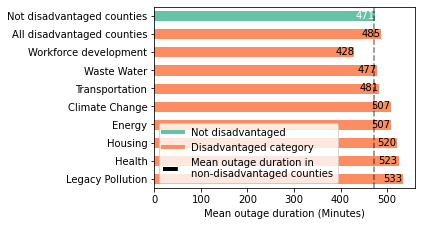

In [183]:
from matplotlib.lines import Line2D
%matplotlib inline
# make first bar first color and all othe other bars the second color
barlist = bar_chart_vals.T['duration'].plot.barh(figsize=(7/3*2, 5/3*2))
barlist.patches[-1].set_color(color_pal[0])
# plt.title('Mean duration of significant outages by disadvantaged category')
[p.set_color(color_pal[1]) for p in barlist.patches[:-1]]
# add number labels to right of bars
for i, p in enumerate(barlist.patches):
    width = p.get_width()
    plt.text(0.96*p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center', color='white' if i == 9 else 'black')

# change fontsize of ytick labels
plt.yticks(fontsize=10)
# plt.axvline(x=bar_chart_vals.loc['duration', 'All other counties'], 
plt.axvline(x=bar_chart_vals.loc['duration', 'Not disadvantaged counties'], 
    color='black', linestyle='--', 
    alpha=0.5, label = 'Mean outage duration in non-disadvantaged counties')
plt.legend(handles=[Line2D([0], [0], color=color_pal[0], lw=4, label='Not disadvantaged'),
                    Line2D([0], [0], color=color_pal[1], lw=4, label='Disadvantaged category'),
                    Line2D([0], [0], color='black', lw=4, linestyle='--', label='Mean outage duration in \nnon-disadvantaged counties')
                     ],
                    loc='lower left')
plt.xlabel('Mean outage duration (Minutes)')
fig = plt.gcf()
# plt.hline(y = bar_chart_vals.loc['duration', 'All other counties'])
# draw dotted horizontal line
# plt.xlim(350, 550)

In [184]:
fig.savefig(PROJECT / 'mean-social-vulnerability-duration.pdf', bbox_inches='tight')

In [46]:
from matplotlib.lines import Line2D
# make first bar first color and all othe other bars the second color
barlist = bar_chart_vals.T['duration'].plot.barh()
barlist.patches[-1].set_color(color_pal[0])
plt.title('Mean duration of significant outages by disadvantaged category')
[p.set_color(color_pal[1]) for p in barlist.patches[:-1]]
# add number labels to right of bars
for i, p in enumerate(barlist.patches):
    width = p.get_width()
    plt.text(0.96*p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center', color='white' if i == 9 else 'black')
plt.axvline(x=bar_chart_vals.loc['duration', 'All other counties'], 
    color='black', linestyle='--', 
    alpha=0.5, label = 'Mean outage duration in all other counties')
plt.legend(handles=[Line2D([0], [0], color=color_pal[0], lw=4, label='Not disadvantaged'),
                    Line2D([0], [0], color=color_pal[1], lw=4, label='Disadvantaged category'),
                    Line2D([0], [0], color='black', lw=4, linestyle='--', label='Mean outage duration in all other counties')
                     ],
                    loc='lower left')
plt.xlabel('Mean outage duration (Minutes)')
# plt.hline(y = bar_chart_vals.loc['duration', 'All other counties'])
# draw dotted horizontal line
# plt.xlim(350, 550)

TypeError: unsupported operand type(s) for +: 'numpy.int64' and 'Timedelta'

In [97]:
other = bar_chart_vals['All other counties']
all_disadvantaged = bar_chart_vals['All disadvantaged counties']
bar_chart_vals = bar_chart_vals.iloc[:, 2:].T.sort_values(by=['sum'], ascending=False)
bar_chart_vals = pd.concat([bar_chart_vals.T, all_disadvantaged, other], axis=1)

In [99]:
bar_chart_vals.loc['sum']

Housing                       333.484757
Transportation                322.438833
Legacy Pollution              311.288795
Workforce development         310.433210
Waste Water                   307.163313
Climate Change                143.072689
Energy                        137.743223
Health                        100.580869
All disadvantaged counties    207.009799
All other counties            227.484552
Name: sum, dtype: float64

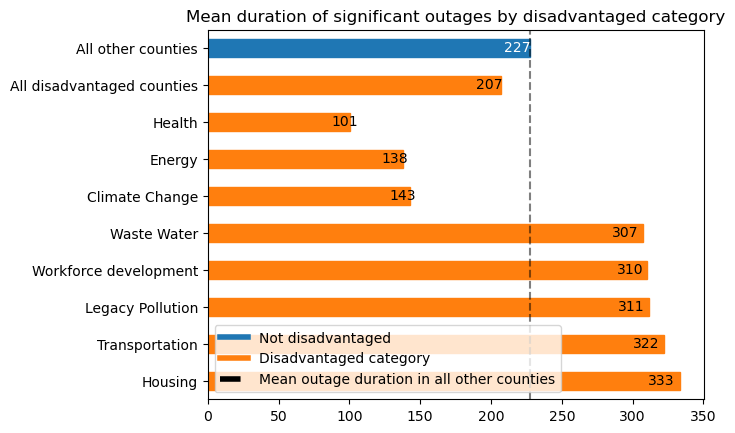

In [100]:
from matplotlib.lines import Line2D
# make first bar first color and all othe other bars the second color
barlist = bar_chart_vals.T['sum'].plot.barh()
barlist.patches[-1].set_color(color_pal[0])
plt.title('Mean duration of significant outages by disadvantaged category')
[p.set_color(color_pal[1]) for p in barlist.patches[:-1]]
# add number labels to right of bars
for i, p in enumerate(barlist.patches):
    width = p.get_width()
    plt.text(0.96*p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center', color='white' if i == 9 else 'black')
plt.axvline(x=bar_chart_vals.loc['sum', 'All other counties'], 
    color='black', linestyle='--', 
    alpha=0.5, label = 'Mean outage duration in all other counties')
plt.legend(handles=[Line2D([0], [0], color=color_pal[0], lw=4, label='Not disadvantaged'),
                    Line2D([0], [0], color=color_pal[1], lw=4, label='Disadvantaged category'),
                    Line2D([0], [0], color='black', lw=4, linestyle='--', label='Mean outage duration in all other counties')
                     ],
                    loc='lower left')
# plt.hline(y = bar_chart_vals.loc['duration', 'All other counties'])
# draw dotted horizontal line
# plt.xlim(350, 550)

(300.0, 550.0)

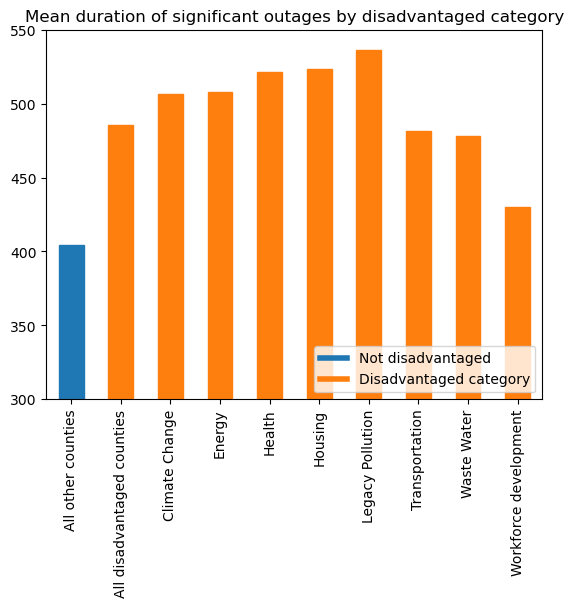

In [27]:
from matplotlib.lines import Line2D
# make first bar first color and all othe other bars the second color
barlist = bar_chart_vals.T['duration'].plot.bar()
barlist.patches[0].set_color(color_pal[0])
plt.title('Mean duration of significant outages by disadvantaged category')
[p.set_color(color_pal[1]) for p in barlist.patches[1:]]
plt.legend(handles=[Line2D([0], [0], color=color_pal[0], lw=4, label='Not disadvantaged'),
                    Line2D([0], [0], color=color_pal[1], lw=4, label='Disadvantaged category')],
                    loc='lower right')
plt.ylim(300, 550)

In [164]:
agg_outage_events(non_disadvantaged).mean()

sum         227.484552
duration    470.807800
dtype: float64

In [166]:
agg_outage_events(filter_fips(outages_2022, disadvantaged_climate_change)).mean()

sum         143.072689
duration    506.467500
dtype: float64

In [92]:
agg_outage_events(filter_fips(outages_2022, disadvantaged_energy)).mean()

sum          36.006092
duration    158.277833
dtype: float64

In [167]:
agg_outage_events(filter_fips(outages_2022, disadvantaged_health)).mean()

sum         100.580869
duration    521.262875
dtype: float64

In [168]:
agg_outage_events(filter_fips(outages_2022, disadvantaged_housing)).mean()

sum         333.484757
duration    523.143162
dtype: float64

In [169]:
agg_outage_events(filter_fips(outages_2022, disadvantaged_legacy_pollution)).mean()

sum         311.288795
duration    536.324218
dtype: float64

In [171]:
agg_outage_events(filter_fips(outages_2022, disadvantaged_transportation)).mean()

sum         322.438833
duration    481.357619
dtype: float64

In [172]:
agg_outage_events(filter_fips(outages_2022, disadvantaged_waste_wastewater)).mean()

sum         307.163313
duration    478.297865
dtype: float64

In [173]:
agg_outage_events(filter_fips(outages_2022, disadvantaged_workface_development)).mean()

sum         310.433210
duration    429.741403
dtype: float64